In [1]:
from google.colab import drive
drive.mount('/content/drive')

feature_path = '/content/drive/My Drive/SIF/features.csv'
train_path = '/content/drive/My Drive/SIF/train.csv'
test_path = '/content/drive/My Drive/SIF/test.csv'

import pandas as pd

feature_df = pd.read_csv(feature_path)
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

### Combining features and train

In [2]:
# Ensure the Date columns are in datetime format for both dataframes
feature_df['Date'] = pd.to_datetime(feature_df['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Group by 'Store' and 'Date', and sum the 'Weekly_Sales'
aggregated_sales = train_df.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales'].sum()

# Merge the aggregated sales data with the features dataset
df = pd.merge(aggregated_sales, feature_df, on=['Store', 'Date'], how='inner')

# Dropping Markdown Columns for now
df = df.drop(columns=['MarkDown1', 'MarkDown2' , "MarkDown3", "MarkDown4","MarkDown5"])
#df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

In [3]:
df.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False


In [4]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday'],
      dtype='object')

### Finding outliers and getting rid of them

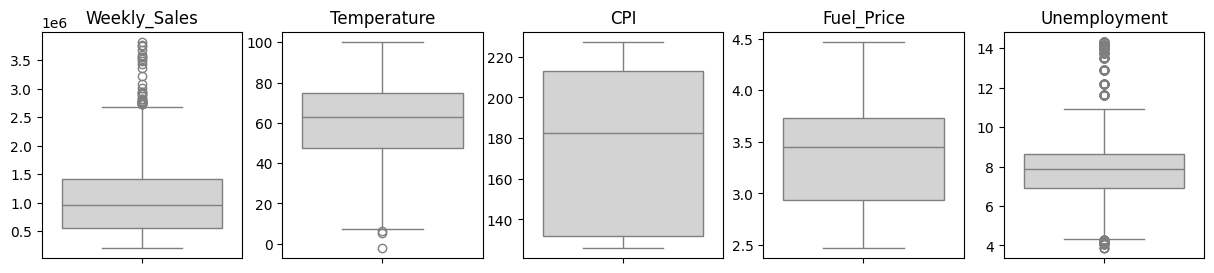

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
columns=['Weekly_Sales','Temperature','CPI','Fuel_Price','Unemployment']
plt.figure(figsize=(15,10))
colors = ['orange', 'grey', 'green', 'magenta','red','blue']
for i,colum  in enumerate(columns,1):
    plt.subplot(3,5,i)
    sns.boxplot(data=df, y=colum,color='lightgrey')
    plt.xlabel('')  # Empty string removes the label
    plt.ylabel('')
    plt.title(colum)

In [6]:
# Removing outliers (518 columns)
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Define outliers as any value below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
        df = df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]
    return df

columns = ['Weekly_Sales', 'Temperature','Unemployment']

df = remove_outliers(df, columns)


### Optimizing Dates

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year']  = df['Date'].dt.year
df.drop('Date',axis=1,inplace=True)
df.head()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Month,Year
0,1,1643690.90,42.31,2.572,211.096358,8.106,False,2,2010
1,1,1641957.44,38.51,2.548,211.242170,8.106,True,2,2010
2,1,1611968.17,39.93,2.514,211.289143,8.106,False,2,2010
3,1,1409727.59,46.63,2.561,211.319643,8.106,False,2,2010
4,1,1554806.68,46.50,2.625,211.350143,8.106,False,3,2010


### Applying transformationa to numerical columns for standardization

In [8]:
# Applying Power Transformation on numeric columns
cols =['Temperature','Fuel_Price','CPI','Unemployment']
df_numeric = df[cols]
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(standardize=True)
df_transformed = pd.DataFrame(pt.fit_transform(df_numeric),columns=cols)

pd.DataFrame({'cols':cols, 'box-cox lamda': pt.lambdas_})

for col in cols:
    df[col] = df_transformed[col]


df.head()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Month,Year
0,1,1643690.90,-1.011497,-1.653883,0.925638,0.294978,False,2,2010
1,1,1641957.44,-1.197216,-1.703740,0.929185,0.294978,True,2,2010
2,1,1611968.17,-1.128488,-1.774223,0.930327,0.294978,False,2,2010
3,1,1409727.59,-0.793628,-1.676745,0.931068,0.294978,False,2,2010
4,1,1554806.68,-0.800285,-1.543474,0.931810,0.294978,False,3,2010


In [9]:
# Mapping 2020 to year 1, 2011 to year 2 and so on
yr = {2010: 1, 2011: 2, 2012: 0}
df['Year'] = df['Year'].map(yr)

In [10]:
df.sample(8)

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Month,Year
3136,22,1060906.75,-0.087113,1.915911,-1.032513,0.381448,False,8,0
6336,45,1002364.34,NaN,NaN,NaN,NaN,False,12,1
657,5,291024.98,0.121317,0.856425,1.184340,-1.417291,False,9,2
1257,9,677885.99,-0.073199,0.560122,1.312979,-2.163182,False,4,0
4608,33,246277.18,-0.590083,0.230794,-0.876950,0.819577,False,9,1
6051,43,615761.77,NaN,NaN,NaN,NaN,False,12,1
2109,15,561137.06,0.037674,0.436020,0.607059,-1.326631,False,2,0
4200,30,470921.24,0.020237,1.290221,0.596294,0.281945,True,2,2


## Building the Model

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Splitting Data into Training and Validation

In [12]:
X = df.drop(['Weekly_Sales'],axis=1)
Y = df['Weekly_Sales']
x_train,x_val,y_train,y_val=train_test_split(X,Y,random_state=42,test_size=0.2)
print("Original shape--->",df.shape)
print("Training shape--->",x_train.shape)
print("Testing shape--->",x_val.shape)

Original shape---> (5917, 9)
Training shape---> (4733, 8)
Testing shape---> (1184, 8)


### Applying one-hot encoing to Store colunm

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [14]:
x_train = pd.DataFrame(x_train, columns=X.columns)
x_val = pd.DataFrame(x_val, columns=X.columns)

transformer = ColumnTransformer(transformers=[
    ('tf', OneHotEncoder(sparse=False, drop='first'), ['Store'])
], remainder='passthrough')

# Fit and transform the training set
x_train_transformed = transformer.fit_transform(x_train)
x_val_transformed = transformer.transform(x_val)

# Get the new column names from OneHotEncoder and add back the remainder columns
new_columns = transformer.named_transformers_['tf'].get_feature_names_out(['Store'])
remainder_columns = x_train.drop(['Store'], axis=1).columns
all_columns = list(new_columns) + list(remainder_columns)

x_train = pd.DataFrame(x_train_transformed, columns=all_columns)
x_val = pd.DataFrame(x_val_transformed, columns=all_columns)

print("Transformed training shape--->", x_train.shape)
print("Transformed testing shape--->", x_val.shape)

Transformed training shape---> (4733, 51)
Transformed testing shape---> (1184, 51)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Training and prediction

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function for training and evaluating a model
def pred_model(model, X_train, Y_train, X_val, Y_val):
    c = model()

    # Training on train data
    c.fit(X_train, Y_train)

    #Evaluating on Validation Data
    y_pred = c.predict(X_val)

    print(f"Model: {model}")
    print(f'MSE: {mean_squared_error(Y_val, y_pred)}')
    print(f'MAE: {mean_absolute_error(Y_val, y_pred)}')
    print(f'R2 : {r2_score(Y_val, y_pred)}')

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Impute missing values in training and validation sets
x_train_imputed = imputer.fit_transform(x_train)
x_val_imputed = imputer.transform(x_val)

In [16]:
pred_model(LinearRegression,x_train_imputed,y_train,x_val_imputed,y_val)

Model: <class 'sklearn.linear_model._base.LinearRegression'>
MSE: 19817149076.187584
MAE: 86719.16843210724
R2 : 0.9374813772799636


In [17]:
pred_model(RandomForestRegressor,x_train_imputed,y_train,x_val_imputed,y_val)

Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
MSE: 15849328104.725441
MAE: 67990.46678339339
R2 : 0.9499989549285853


In [18]:
from xgboost import XGBRegressor
pred_model(XGBRegressor,x_train_imputed,y_train,x_val_imputed,y_val)

Model: <class 'xgboost.sklearn.XGBRegressor'>
MSE: 11437264911.530699
MAE: 64285.624342139985
R2 : 0.9639180162997161


After Some Data preprocessing we come to a Validation accuracy of about 95% with the XGboost Regressor model

## Making Predictions of Test Data

### Preparing test dataset by merging with features

In [19]:
feature_df = pd.read_csv(feature_path)
test_df = pd.read_csv(test_path)

test_df['Date'] = pd.to_datetime(test_df['Date'])

# Drop the 'Dept' column and remove duplicates
test_df = test_df.drop(columns=['Dept']).drop_duplicates()
test_df = test_df.drop(columns=['IsHoliday'])

test_df['Date'] = pd.to_datetime(test_df['Date'])
feature_df['Date'] = pd.to_datetime(feature_df['Date'])

# Merge test_df with features_df on 'Store' and 'Date'
test_merged = pd.merge(test_df, feature_df, on=['Store', 'Date'], how='inner')

# Drop MarkDown columns
test_merged = test_merged.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

# Create 'Month' and 'Year' from 'Date' and drop 'Date'
test_merged['Month'] = test_merged['Date'].dt.month
test_merged['Year'] = test_merged['Date'].dt.year
test_merged = test_merged.drop(columns=['Date'])

In [20]:
test_merged.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Month,Year
0,1,55.32,3.386,223.462779,6.573,False,11,2012
1,1,61.24,3.314,223.481307,6.573,False,11,2012
2,1,52.92,3.252,223.512911,6.573,False,11,2012
3,1,56.23,3.211,223.561947,6.573,True,11,2012
4,1,52.34,3.207,223.610984,6.573,False,11,2012


### Applying preprocessing to Test Dataset

In [21]:
# Standardize the numeric columns using the PowerTransformer
from sklearn.preprocessing import PowerTransformer

cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
pt = PowerTransformer(standardize=True)
test_merged[cols] = pt.fit_transform(test_merged[cols])

# Map 'Year' to the same values as the train data
yr = {2010: 1, 2011: 2, 2012: 0,2013:3}
test_merged['Year'] = test_merged['Year'].map(yr)


In [22]:
test_merged.sample(10)

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Month,Year
375,10,0.749506,1.627281,-1.104193,-0.010653,False,4,3
1362,35,1.402449,0.079557,NaN,NaN,False,7,3
847,22,0.106118,0.149085,NaN,NaN,False,5,3
1753,45,1.515959,0.630086,NaN,NaN,False,7,3
118,4,0.257671,-1.029614,-1.150655,-2.047198,False,11,0
125,4,-0.890145,-1.764683,-1.135474,-2.047198,True,12,0
1213,32,-0.842482,-0.653263,0.619467,0.464876,False,11,0
960,25,0.079898,0.352428,0.983334,0.240142,False,4,3
1179,31,-0.823409,-1.646443,1.095933,-0.367694,False,1,3
1309,34,0.200346,-0.184090,-1.106197,1.195564,False,4,3


In [23]:
# Apply one-hot encoding to the 'Store' column
transformer = ColumnTransformer(transformers=[
    ('tf', OneHotEncoder(sparse=False, drop='first'), ['Store'])
], remainder='passthrough')

test_transformed = transformer.fit_transform(test_merged)

# Get the new column names from the one-hot encoding and add back the remaining columns
new_columns = transformer.named_transformers_['tf'].get_feature_names_out(['Store'])
remainder_columns = test_merged.drop(columns=['Store']).columns
all_columns = list(new_columns) + list(remainder_columns)

# Convert the transformed array back into a DataFrame
test_df_transformed = pd.DataFrame(test_transformed, columns=all_columns)

# Handle missing values (if any) using SimpleImputer
imputer = SimpleImputer(strategy='mean')
test_df_imputed = imputer.fit_transform(test_df_transformed)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
test_df_transformed.sample(8)

,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,...,Store_43,Store_44,Store_45,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Month,Year
679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.455836,1.248128,-0.910533,0.696699,False,2,3
1519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.453789,-0.167356,NaN,NaN,False,7,3
733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.407809,0.888402,NaN,NaN,False,6,3
410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.801698,0.066589,1.18336,-0.452562,False,3,3
1686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-2.172524,-1.952834,-1.132073,-1.224102,False,1,3
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.036033,0.114244,1.116735,-0.18062,False,3,3
1173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.224451,-1.477823,1.08629,-0.411687,True,11,0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.142985,0.254535,NaN,NaN,False,5,3


In [25]:
x_train_imputed.shape

(4733, 51)

In [26]:
xgb_model = XGBRegressor()
xgb_model.fit(x_train_imputed, y_train)
# y_pred = xgb_model.predict(x_val_imputed)

# #x_train_imputed,y_train,x_val_imputed,y_val

# print(f'MSE: {mean_squared_error(y_val, y_pred)}')
# print(f'MAE: {mean_absolute_error(y_val, y_pred)}')
# print(f'R2 : {r2_score(y_val, y_pred)}')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
test_predictions = xgb_model.predict(test_df_imputed)

In [28]:
# Re-add 'Store' and 'Date' for output purposes
final_output = pd.DataFrame({
    'Store': test_df['Store'],
    'Date': test_df['Date'],
    'Predicted_Weekly_Sales': test_predictions
})

# Save the final output to an Excel file
final_output.to_excel('test_predictions.xlsx', index=False)

print("Predictions saved to test_predictions.xlsx.")

Predictions saved to test_predictions.xlsx.
